<h3 style='color:blue' align='center'>Customer Churn Prediction Using Artificial Neural Network (ANN), Logistics Regression , GradientBoostingClassifier, GaussianNB</h3>

# https://medium.com/swlh/churn-prediction-using-machine-learning-25c856201884
#https://towardsdatascience.com/predict-customer-churn-the-right-way-using-pycaret-8ba6541608ac

Customer churn prediction is to measure why customers are leaving a business. In this tutorial we will be looking at customer churn in telecom business. We will build a deep learning model to predict the churn and use precision,recall, f1-score to measure performance of our model

In [1]:
# Import libraries
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.metrics import accuracy_score

import seaborn as sns
import io
import requests

**Load the data**

In [2]:
# Lets look at glimpse of the data
url = "https://raw.githubusercontent.com/kambojrakesh/Customer_Churn_Rate_Prediction/main/customer_churn.csv" # Make sure the url is the raw version of the file on GitHub
download = requests.get(url).content

# Reading the downloaded content and turning it into a pandas dataframe
df = pd.read_csv(io.StringIO(download.decode('utf-8')))

df.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
1198,5542-NKVRU,Female,0,No,No,42,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),20.75,844.45,No
5481,8473-VUVJN,Male,1,No,No,1,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,73.65,73.65,Yes
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
3437,2746-DIJLO,Female,0,No,No,41,Yes,Yes,DSL,No,...,No,No,No,No,One year,Yes,Credit card (automatic),56.30,2364,No
819,4178-EGMON,Male,0,Yes,No,70,Yes,Yes,Fiber optic,Yes,...,No,Yes,No,No,Two year,Yes,Credit card (automatic),88.00,5986.45,No


In [3]:
numerical= df.select_dtypes(include = 'number').columns
print(f'Numerical Columns:  {df[numerical].columns}')
col_int = []

for col in numerical:
    if df[col].dtype == "int64":
        col_int.append(col)

#col_int.remove("Churn")
col_int


Numerical Columns:  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges'], dtype='object')


['SeniorCitizen', 'tenure']

In [4]:
#Check the null values 
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [5]:
df.Churn.value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

In [6]:
#Drop customerID column
df.drop('customerID', axis='columns', inplace=True)


In [7]:
# Check the type of the data 
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [8]:
#check TotalCharges field type 
df.TotalCharges.values

array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      dtype=object)

In [9]:
#Check null values in TotalCharges
df[pd.to_numeric(df.TotalCharges, errors='coerce').isnull()].shape

(11, 20)

In [10]:
#Remove blank string TotalCharges
df=df[df.TotalCharges!=' ']
df.shape

(7032, 20)

In [11]:
#Convert all TotalCharges to float
df.TotalCharges  = pd.to_numeric(df.TotalCharges)
df.TotalCharges.values

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


array([  29.85, 1889.5 ,  108.15, ...,  346.45,  306.6 , 6844.5 ])

In [12]:
df[df.Churn=='No']

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
6,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,No
7,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.90,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7037,Female,0,No,No,72,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),21.15,1419.40,No
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No


**Data Visualization**

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


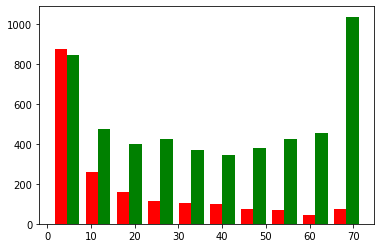

In [13]:
#Data Visualization corrsponding to Churn field
tenure_churn_yes = df[df.Churn=='Yes'].tenure
tenure_churn_no = df[df.Churn=='No'].tenure
plt.hist([tenure_churn_yes, tenure_churn_no], color=['red','green'], label=['churn=yes','churn=no'])
df2=df

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


(array([[ 148.,   57.,  119.,  152.,   53.,  350.,  355.,  319.,  273.,
           43.],
        [1452.,  134.,  246.,  485.,  419.,  544.,  597.,  550.,  485.,
          251.]]),
 array([ 18.25,  28.3 ,  38.35,  48.4 ,  58.45,  68.5 ,  78.55,  88.6 ,
         98.65, 108.7 , 118.75]),
 <a list of 2 Lists of Patches objects>)

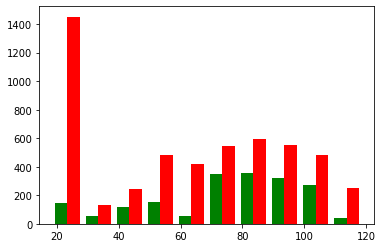

In [14]:
#Data Visualization corrsponding to Churn field based on MonthlyCharges
Mc_churn_yes = df[df.Churn=='Yes'].MonthlyCharges
Mc_churn_no = df[df.Churn=='No'].MonthlyCharges
plt.hist([Mc_churn_yes, Mc_churn_no], color=['green','red'], label=['churn=yes','churn=no'])

In [15]:
# check unique columns
def unique_column_values(df):
    for column in df:
        if df[column].dtype=='object':
            print(f'{column}: {df[column].unique()}')

In [16]:
unique_column_values(df)

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


In [17]:
#Replace No internet service,No phone service fieltds value to no
df.replace('No internet service', 'No', inplace=True)
df.replace('No phone service', 'No', inplace=True)

In [18]:
unique_column_values(df)

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes']
OnlineBackup: ['Yes' 'No']
DeviceProtection: ['No' 'Yes']
TechSupport: ['No' 'Yes']
StreamingTV: ['No' 'Yes']
StreamingMovies: ['No' 'Yes']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


In [19]:
#Convert all all Yes, No to 1,0
yes_no_columns = ['Partner','Dependents','PhoneService','MultipleLines','OnlineSecurity','OnlineBackup',
                  'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaperlessBilling','Churn']
for col in yes_no_columns:
    df[col].replace({'Yes': 1,'No': 0},inplace=True)

In [20]:
#Check all values
for col in df:
    print(f'{col}:{df[col].unique()}')

gender:['Female' 'Male']
SeniorCitizen:[0 1]
Partner:[1 0]
Dependents:[0 1]
tenure:[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
PhoneService:[0 1]
MultipleLines:[0 1]
InternetService:['DSL' 'Fiber optic' 'No']
OnlineSecurity:[0 1]
OnlineBackup:[1 0]
DeviceProtection:[0 1]
TechSupport:[0 1]
StreamingTV:[0 1]
StreamingMovies:[0 1]
Contract:['Month-to-month' 'One year' 'Two year']
PaperlessBilling:[1 0]
PaymentMethod:['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges:[29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
TotalCharges:[  29.85 1889.5   108.15 ...  346.45  306.6  6844.5 ]
Churn:[0 1]


In [21]:
#Convert all all Female, Male to 1,0
df['gender'].replace({'Female':1,'Male':0},inplace=True)

df.gender.unique()

array([1, 0])

In [22]:
#converts categorical data into dummy or indicator variables
df = pd.get_dummies(data=df, columns=['InternetService', 'PaymentMethod', 'Contract'])

In [23]:
df.sample(4)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Contract_Month-to-month,Contract_One year,Contract_Two year
371,0,0,0,0,2,1,1,0,0,0,...,0,1,0,0,0,1,0,1,0,0
3924,1,0,1,1,48,1,1,0,0,0,...,0,1,0,0,0,0,1,0,1,0
919,1,0,0,0,21,1,0,0,1,1,...,0,1,0,0,0,0,1,0,1,0
3597,0,0,1,0,25,1,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0


In [24]:
df.dtypes

gender                                       int64
SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
tenure                                       int64
PhoneService                                 int64
MultipleLines                                int64
OnlineSecurity                               int64
OnlineBackup                                 int64
DeviceProtection                             int64
TechSupport                                  int64
StreamingTV                                  int64
StreamingMovies                              int64
PaperlessBilling                             int64
MonthlyCharges                             float64
TotalCharges                               float64
Churn                                        int64
InternetService_DSL                          uint8
InternetService_Fiber optic                  uint8
InternetService_No             

In [25]:
#subtracts the minimum value in the feature and then divides by the range
cols_to_scale = ['tenure','MonthlyCharges','TotalCharges']

scaler = MinMaxScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

In [26]:
#check whole datset
for col in df:
    print(f'{col}: {df[col].unique()}')

gender: [1 0]
SeniorCitizen: [0 1]
Partner: [1 0]
Dependents: [0 1]
tenure: [0.         0.46478873 0.01408451 0.61971831 0.09859155 0.29577465
 0.12676056 0.38028169 0.85915493 0.16901408 0.21126761 0.8028169
 0.67605634 0.33802817 0.95774648 0.71830986 0.98591549 0.28169014
 0.15492958 0.4084507  0.64788732 1.         0.22535211 0.36619718
 0.05633803 0.63380282 0.14084507 0.97183099 0.87323944 0.5915493
 0.1971831  0.83098592 0.23943662 0.91549296 0.11267606 0.02816901
 0.42253521 0.69014085 0.88732394 0.77464789 0.08450704 0.57746479
 0.47887324 0.66197183 0.3943662  0.90140845 0.52112676 0.94366197
 0.43661972 0.76056338 0.50704225 0.49295775 0.56338028 0.07042254
 0.04225352 0.45070423 0.92957746 0.30985915 0.78873239 0.84507042
 0.18309859 0.26760563 0.73239437 0.54929577 0.81690141 0.32394366
 0.6056338  0.25352113 0.74647887 0.70422535 0.35211268 0.53521127]
PhoneService: [0 1]
MultipleLines: [0 1]
OnlineSecurity: [0 1]
OnlineBackup: [1 0]
DeviceProtection: [0 1]
TechSupport: [

In [27]:
df.describe()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Contract_Month-to-month,Contract_One year,Contract_Two year
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,...,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.495307,0.162400,0.482509,0.298493,0.442560,0.903299,0.421928,0.286547,0.344852,0.343857,...,0.343572,0.440273,0.216155,0.219283,0.216297,0.336320,0.228100,0.551052,0.209329,0.239619
std,0.500014,0.368844,0.499729,0.457629,0.345708,0.295571,0.493902,0.452180,0.475354,0.475028,...,0.474934,0.496455,0.411650,0.413790,0.411748,0.472483,0.419637,0.497422,0.406858,0.426881
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.112676,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.394366,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,0.760563,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


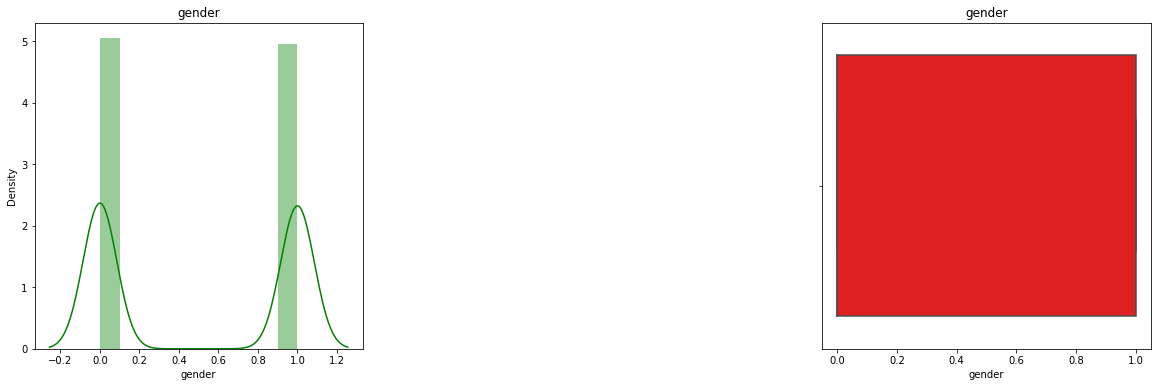

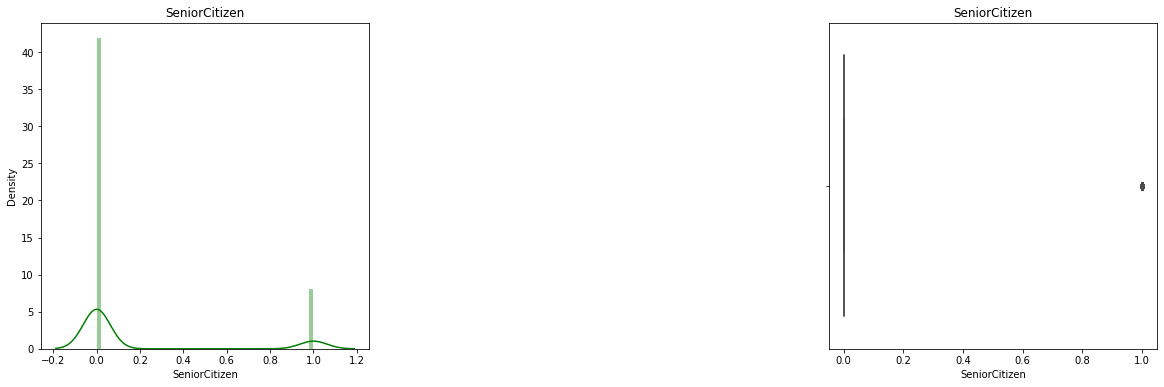

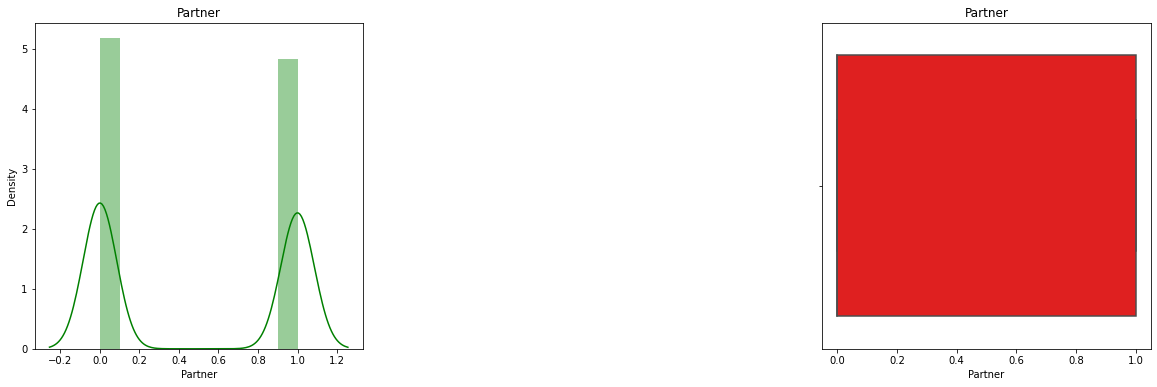

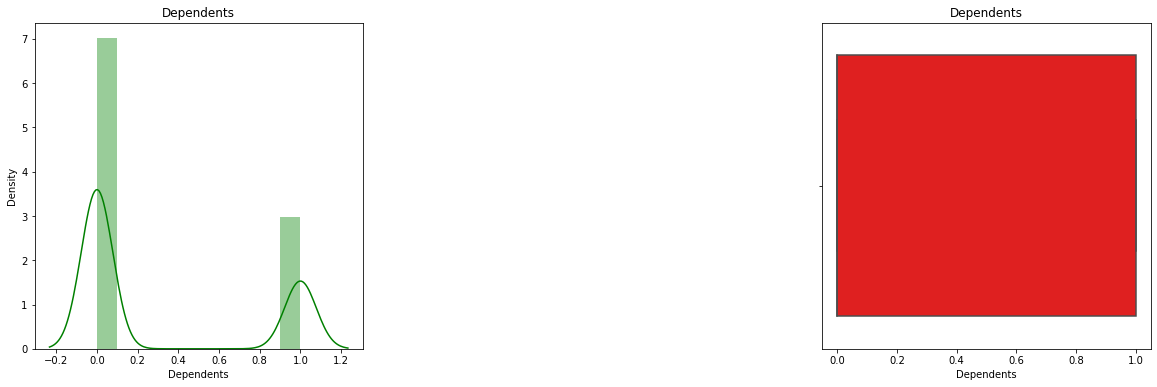

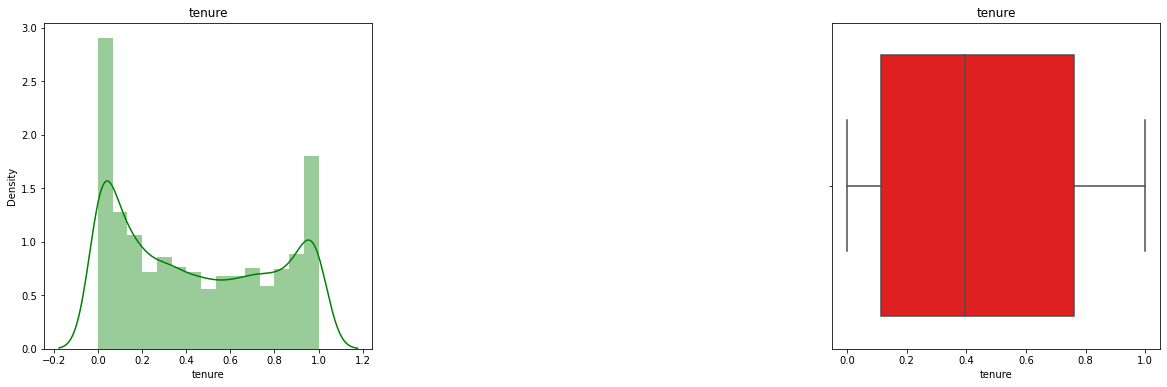

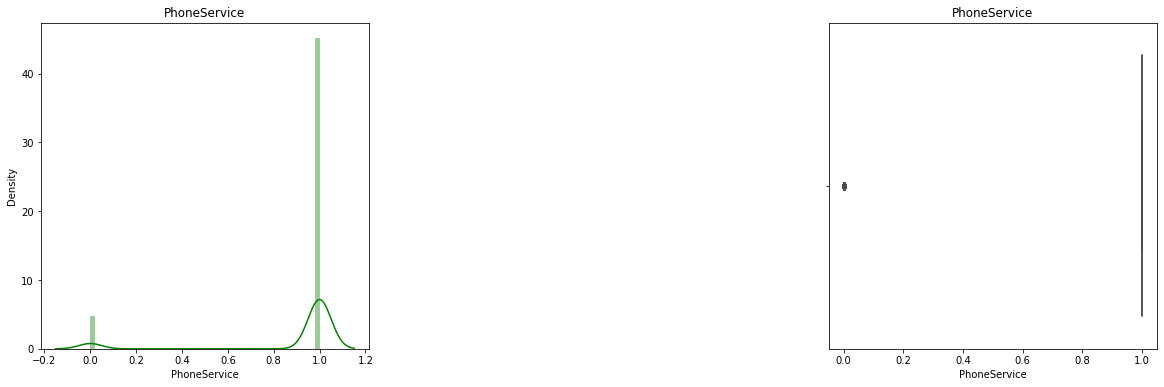

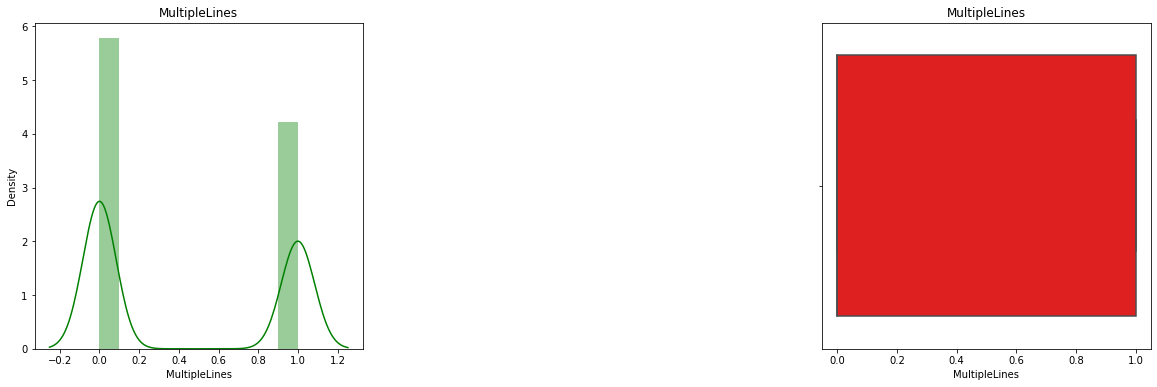

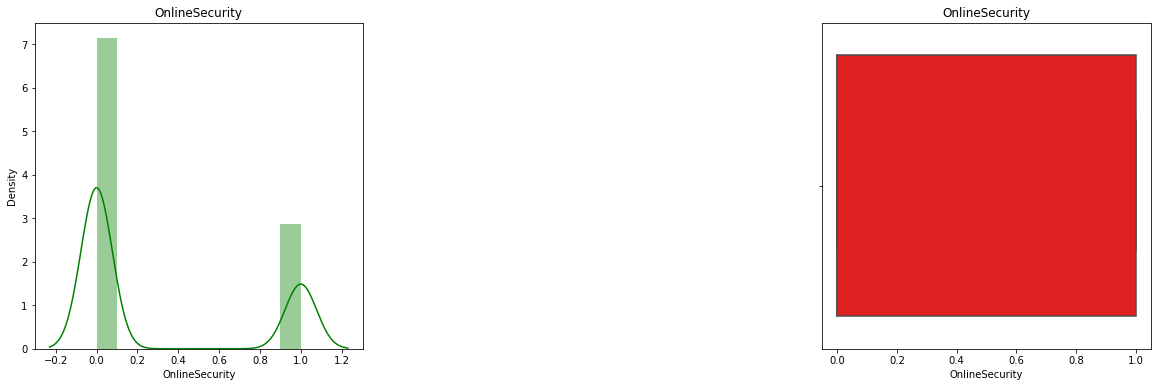

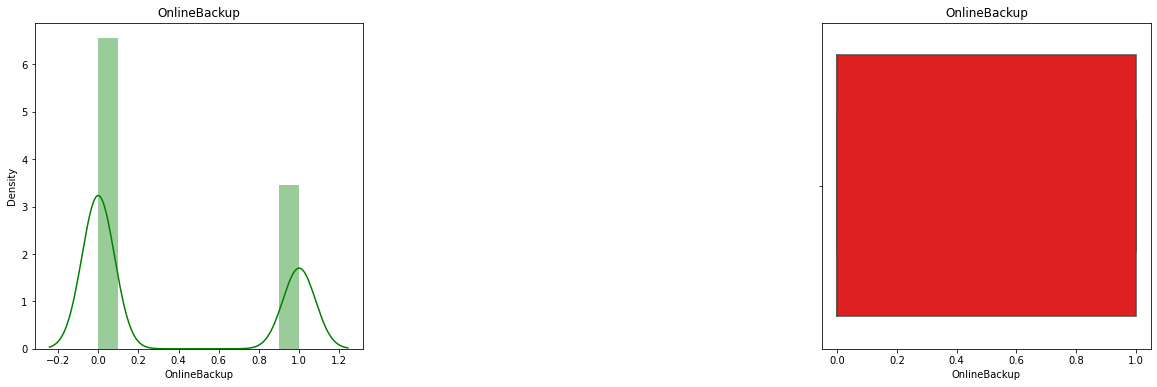

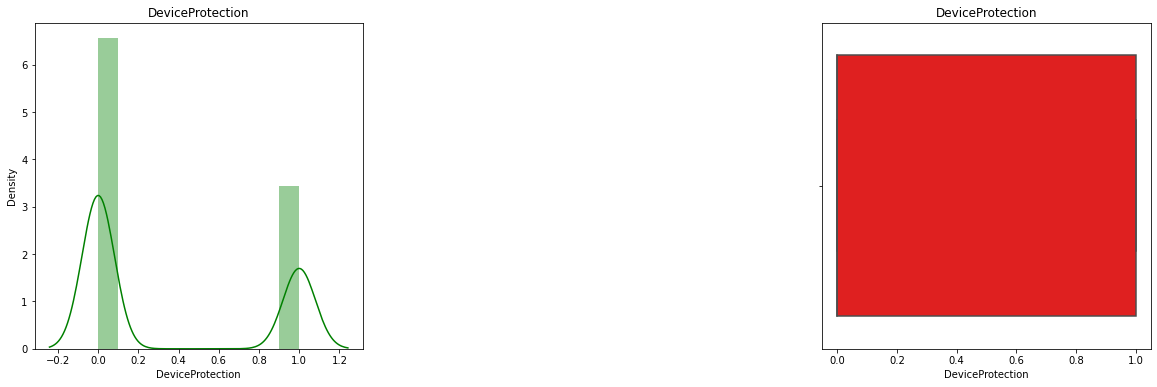

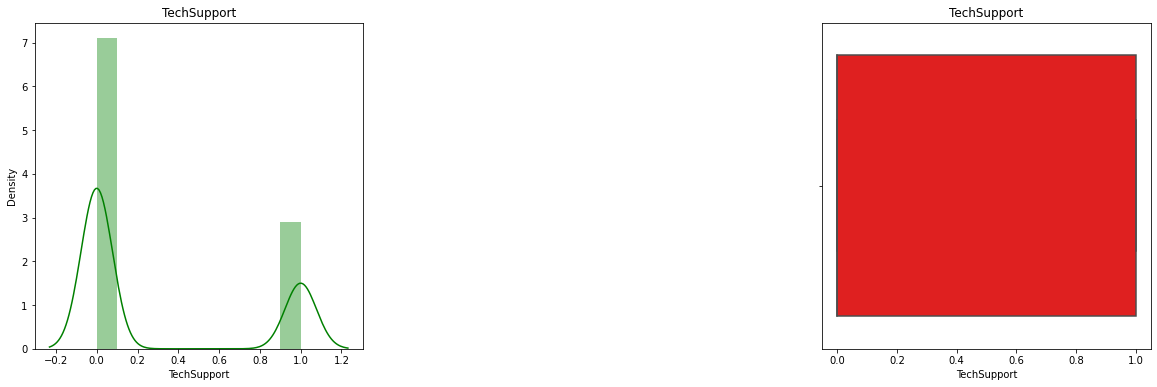

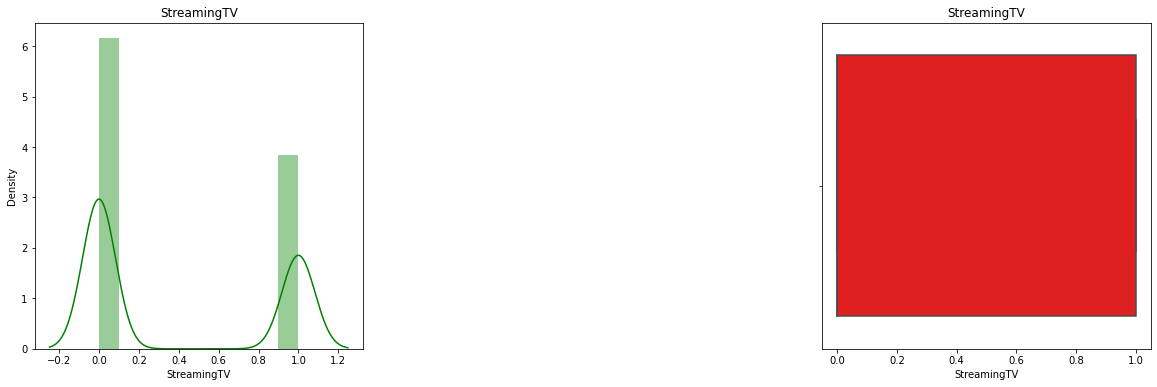

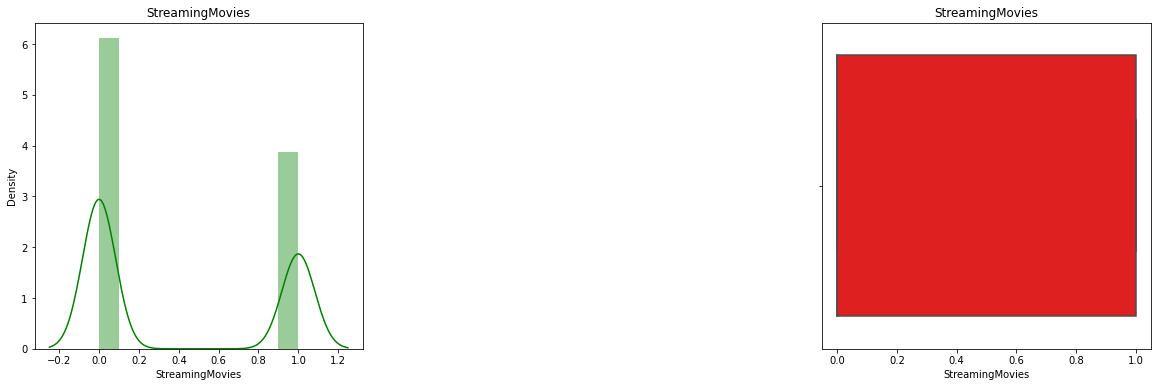

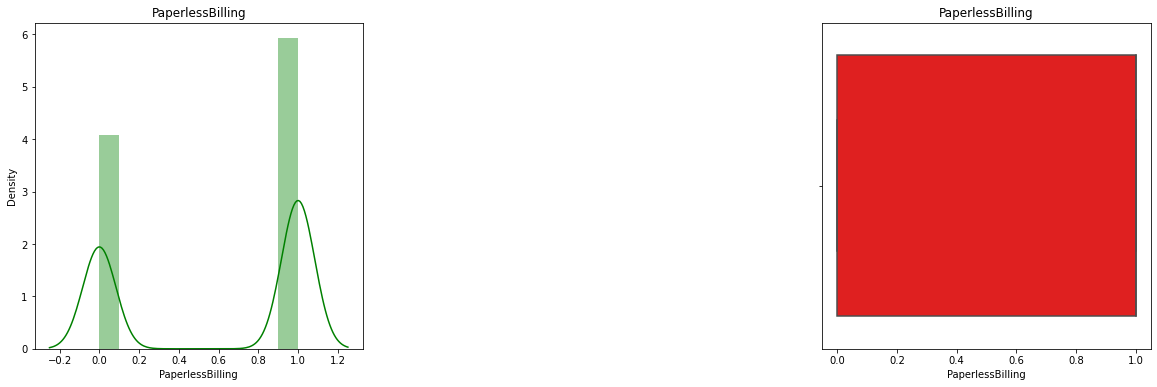

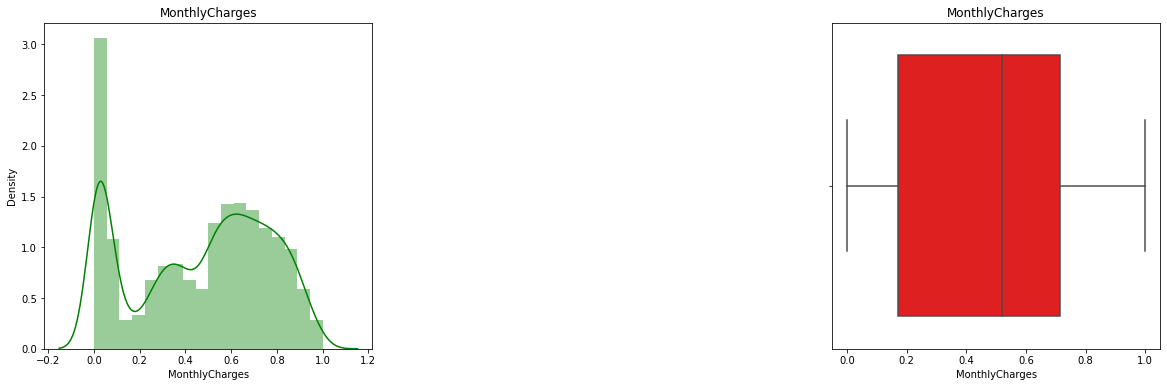

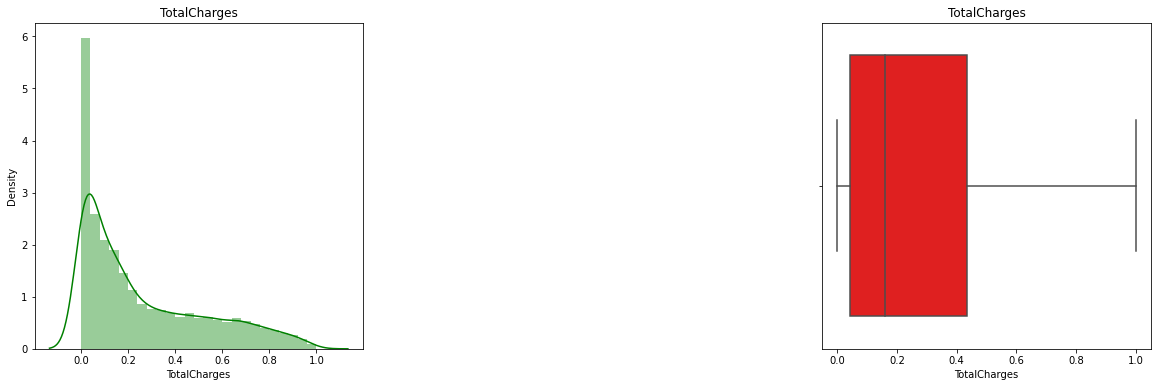

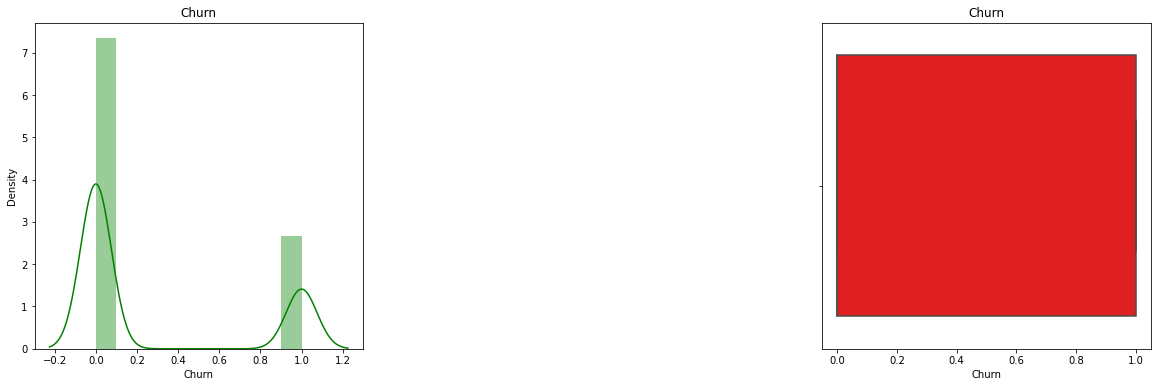

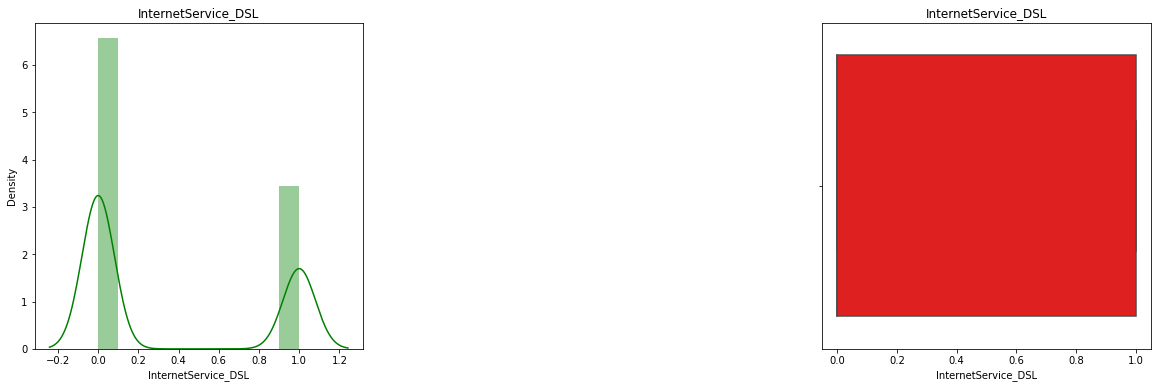

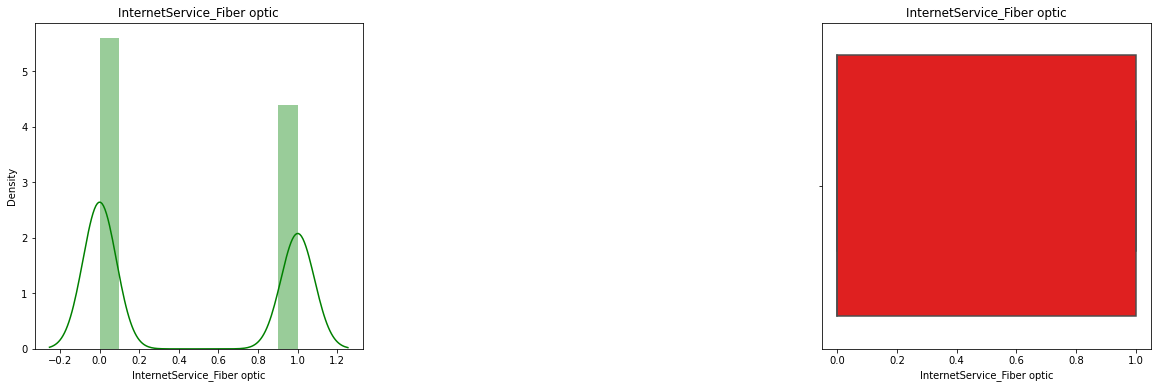

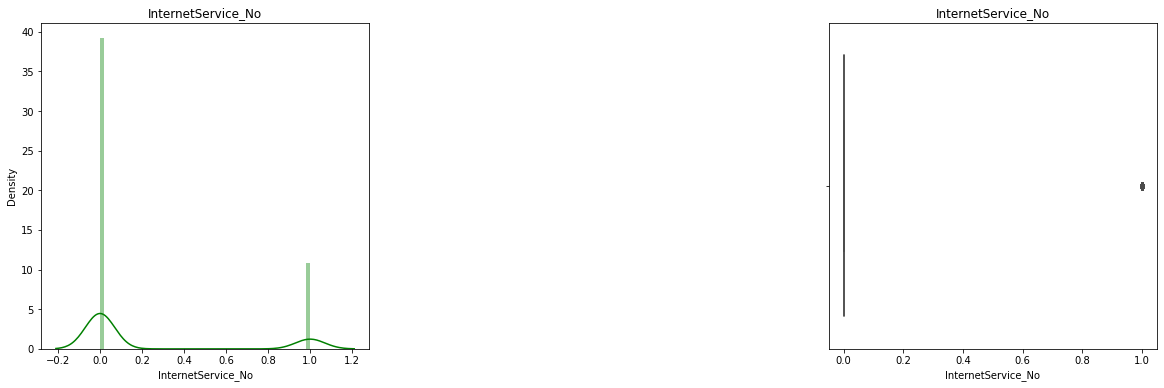

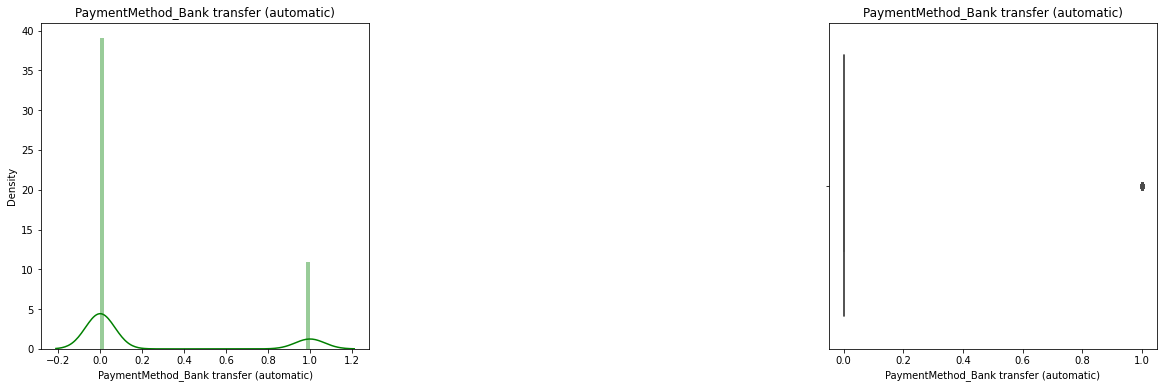

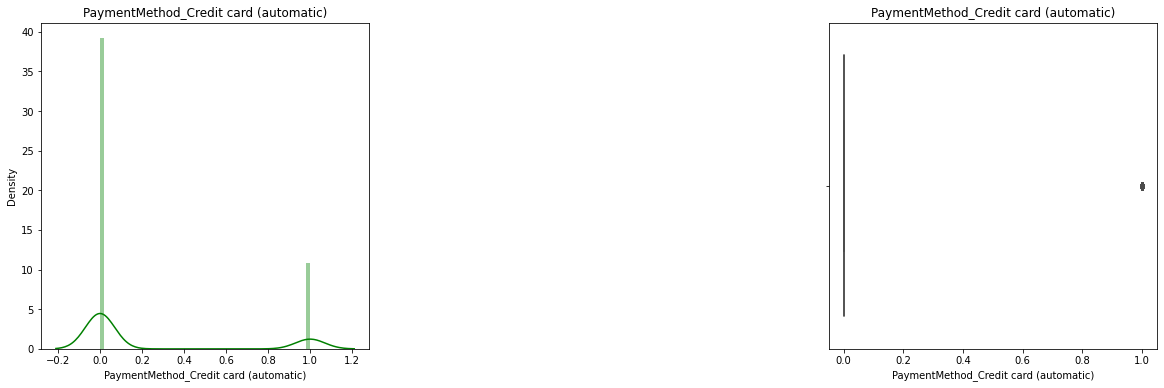

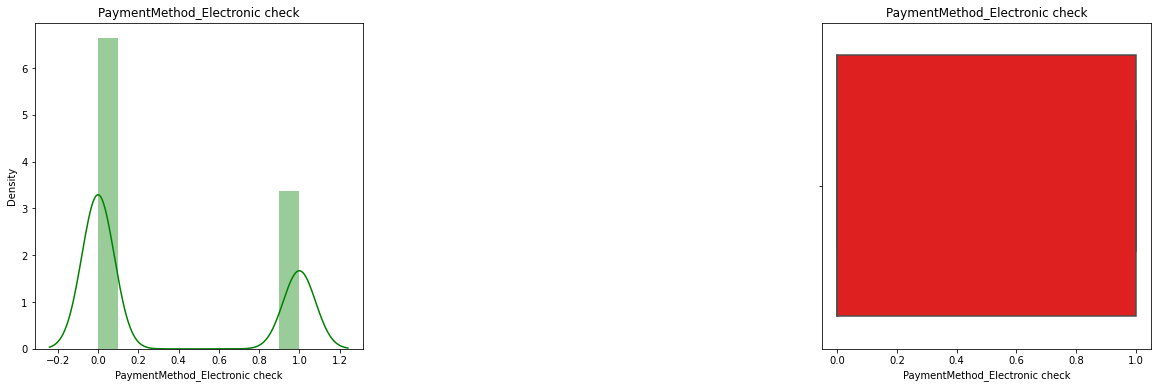

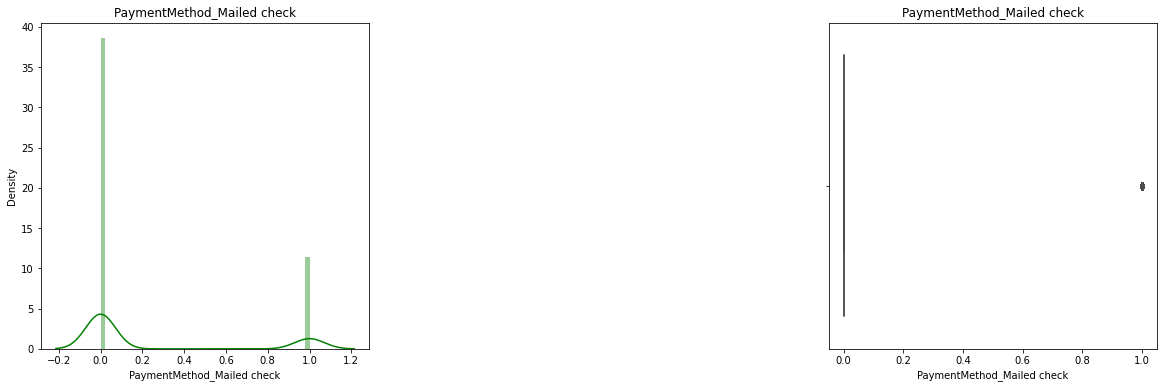

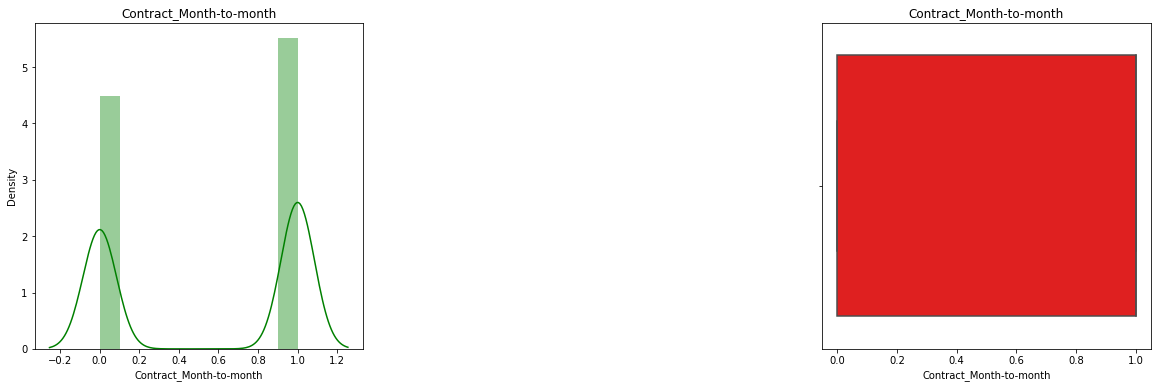

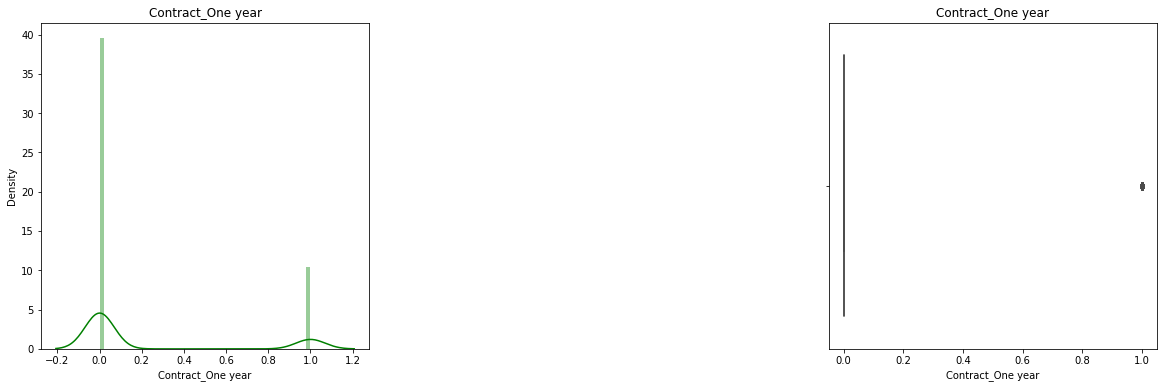

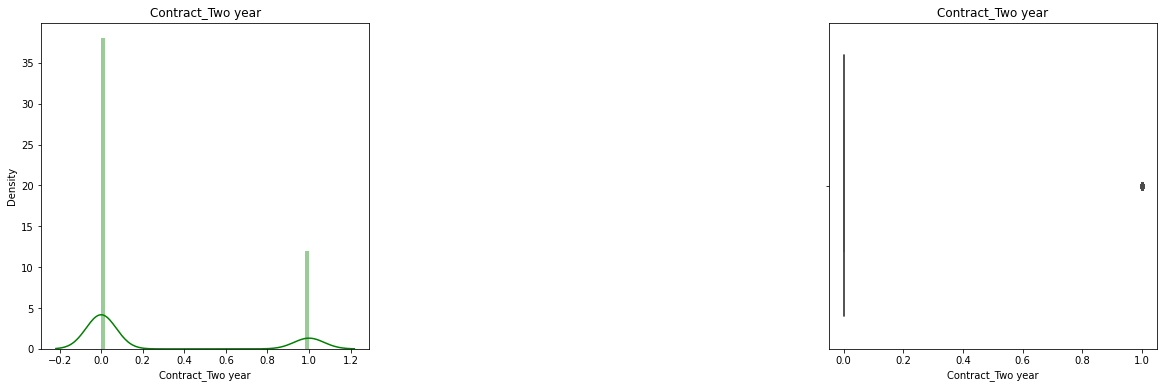

In [28]:
#Univariate plot
### histogram and boxplot
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
for col in df:
    #print(f'{col}: {df[col].unique()}')

    plt.figure(figsize=(20,6))
    plt.subplot(1, 3, 1)
    plt.title(col)
    sns.distplot(df[col],color='green')

    plt.subplot(1, 3, 3)
    plt.title(col)
    sns.boxplot(df[col],color='red')

plt.show()

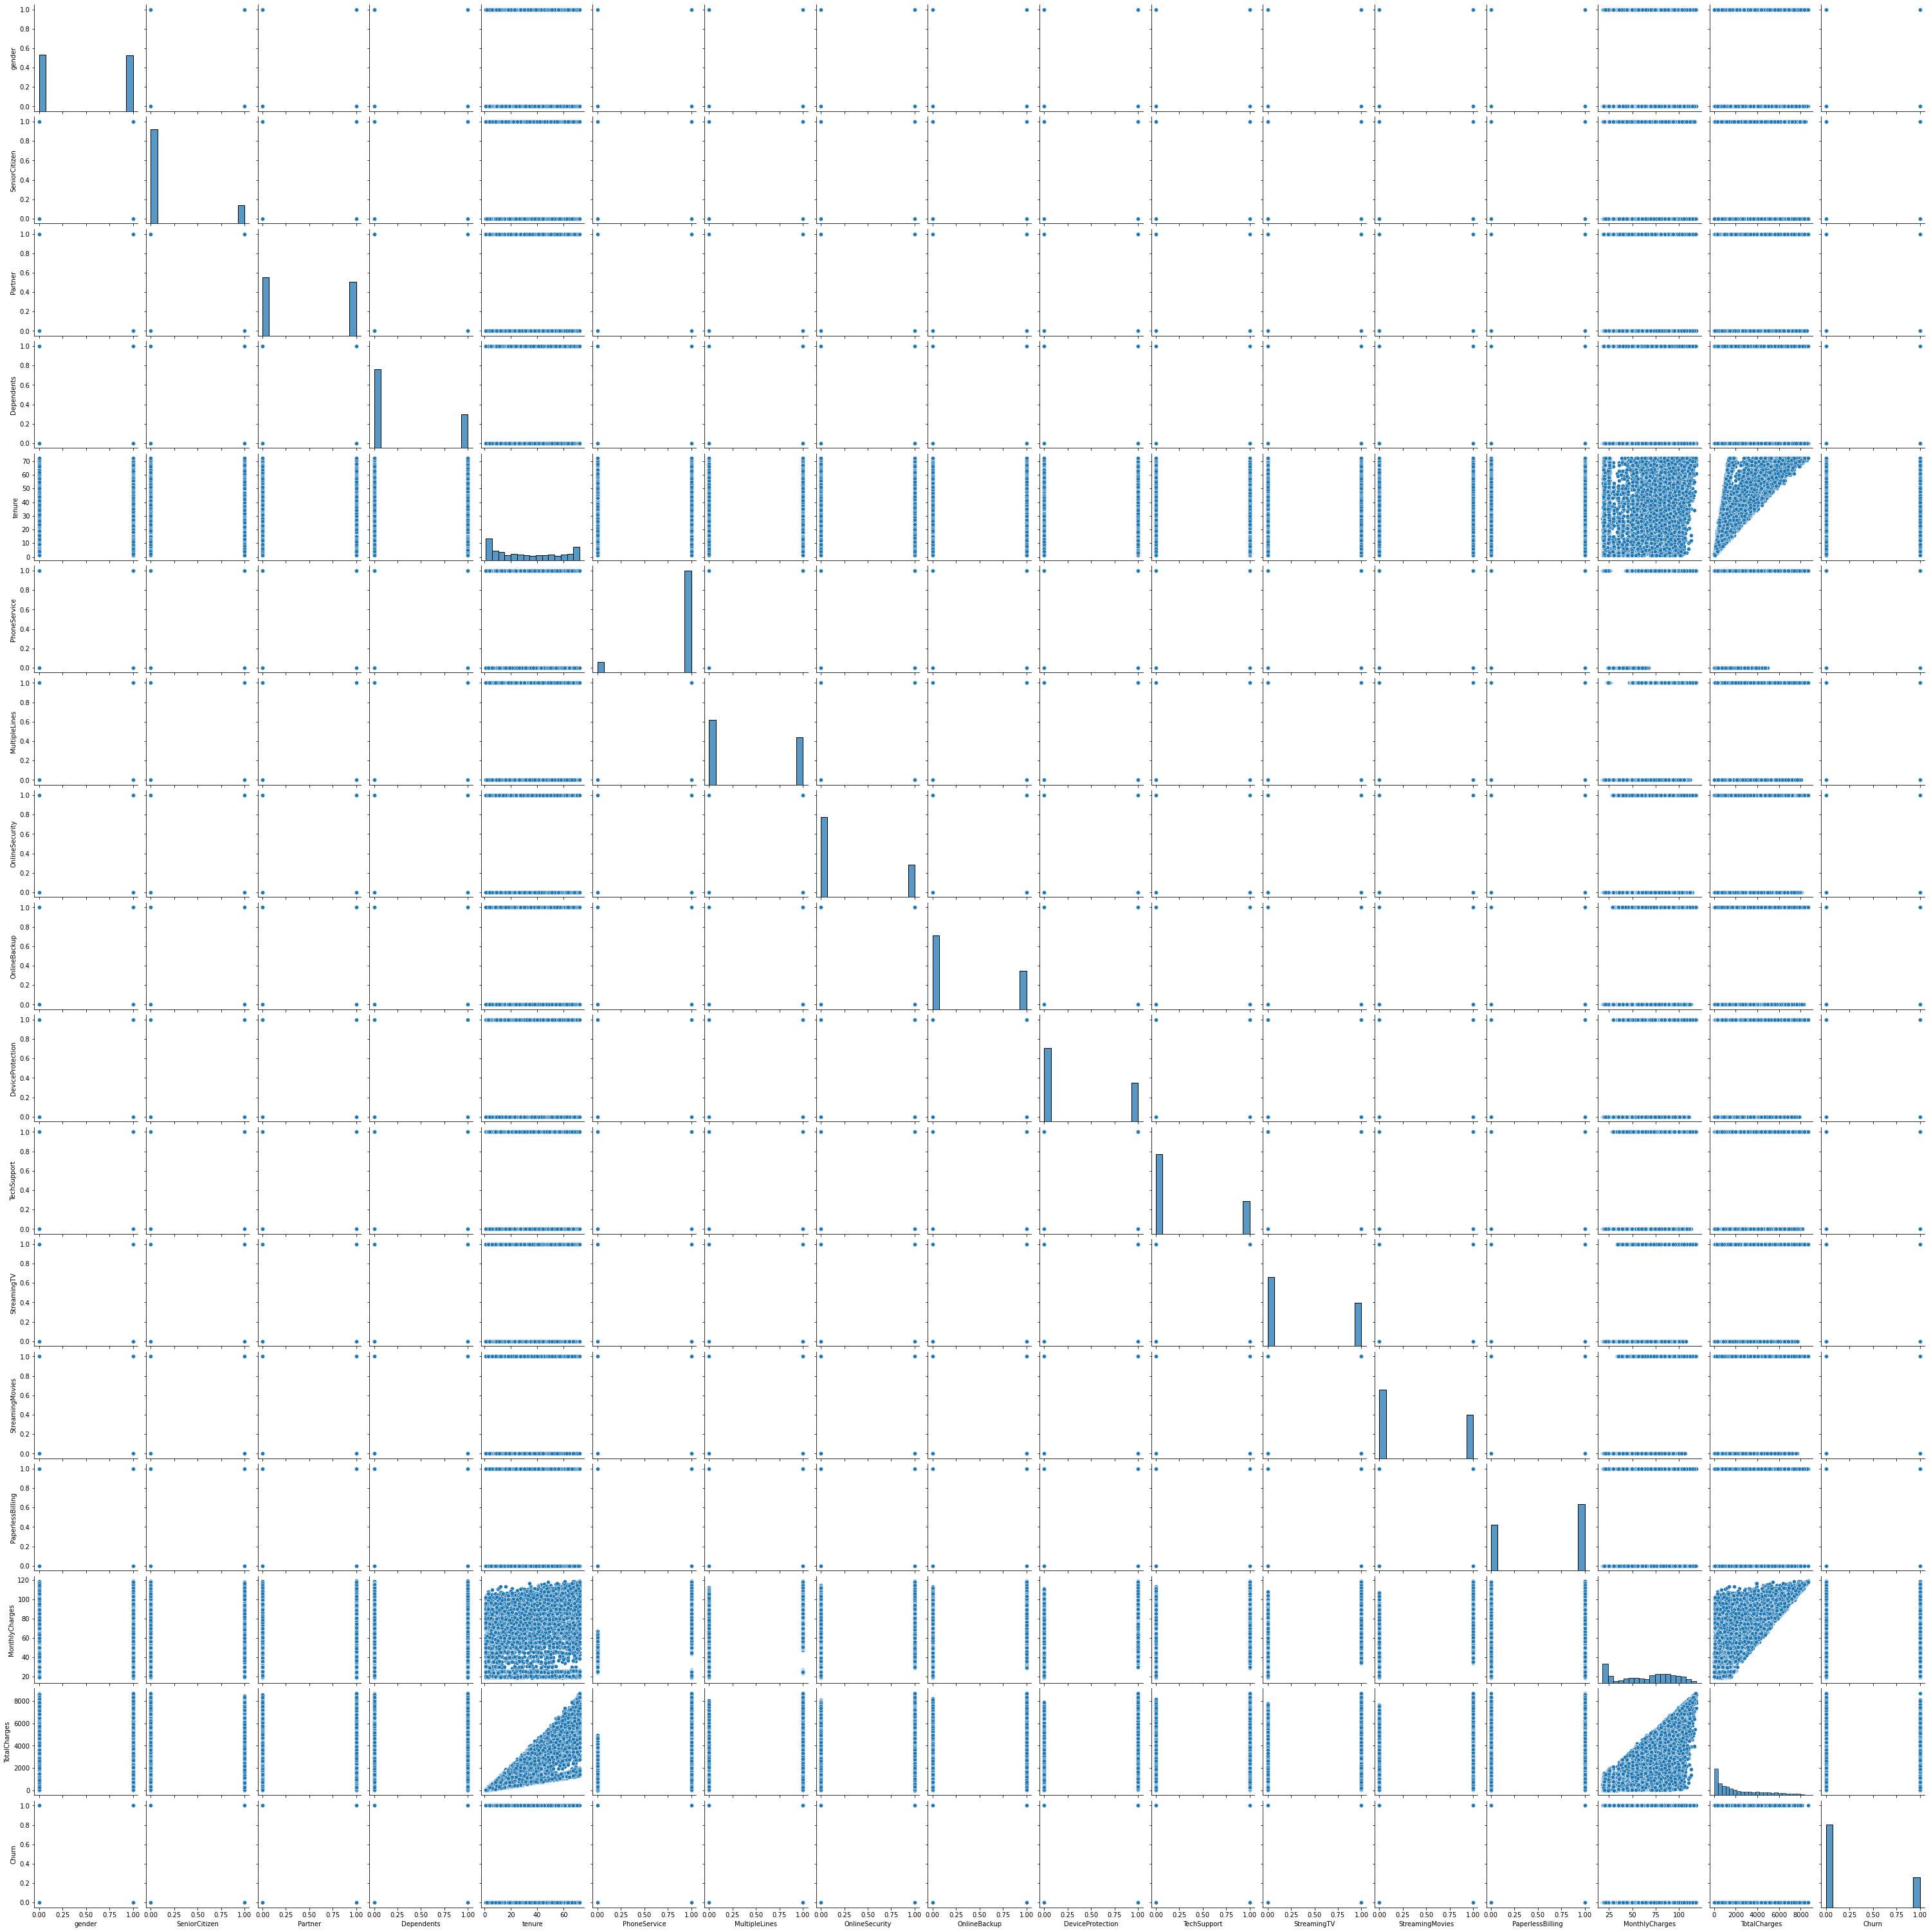

In [29]:
#Bi-Variate plot
#Plottted heatmap on datset
sns.pairplot(df2, kind="scatter")

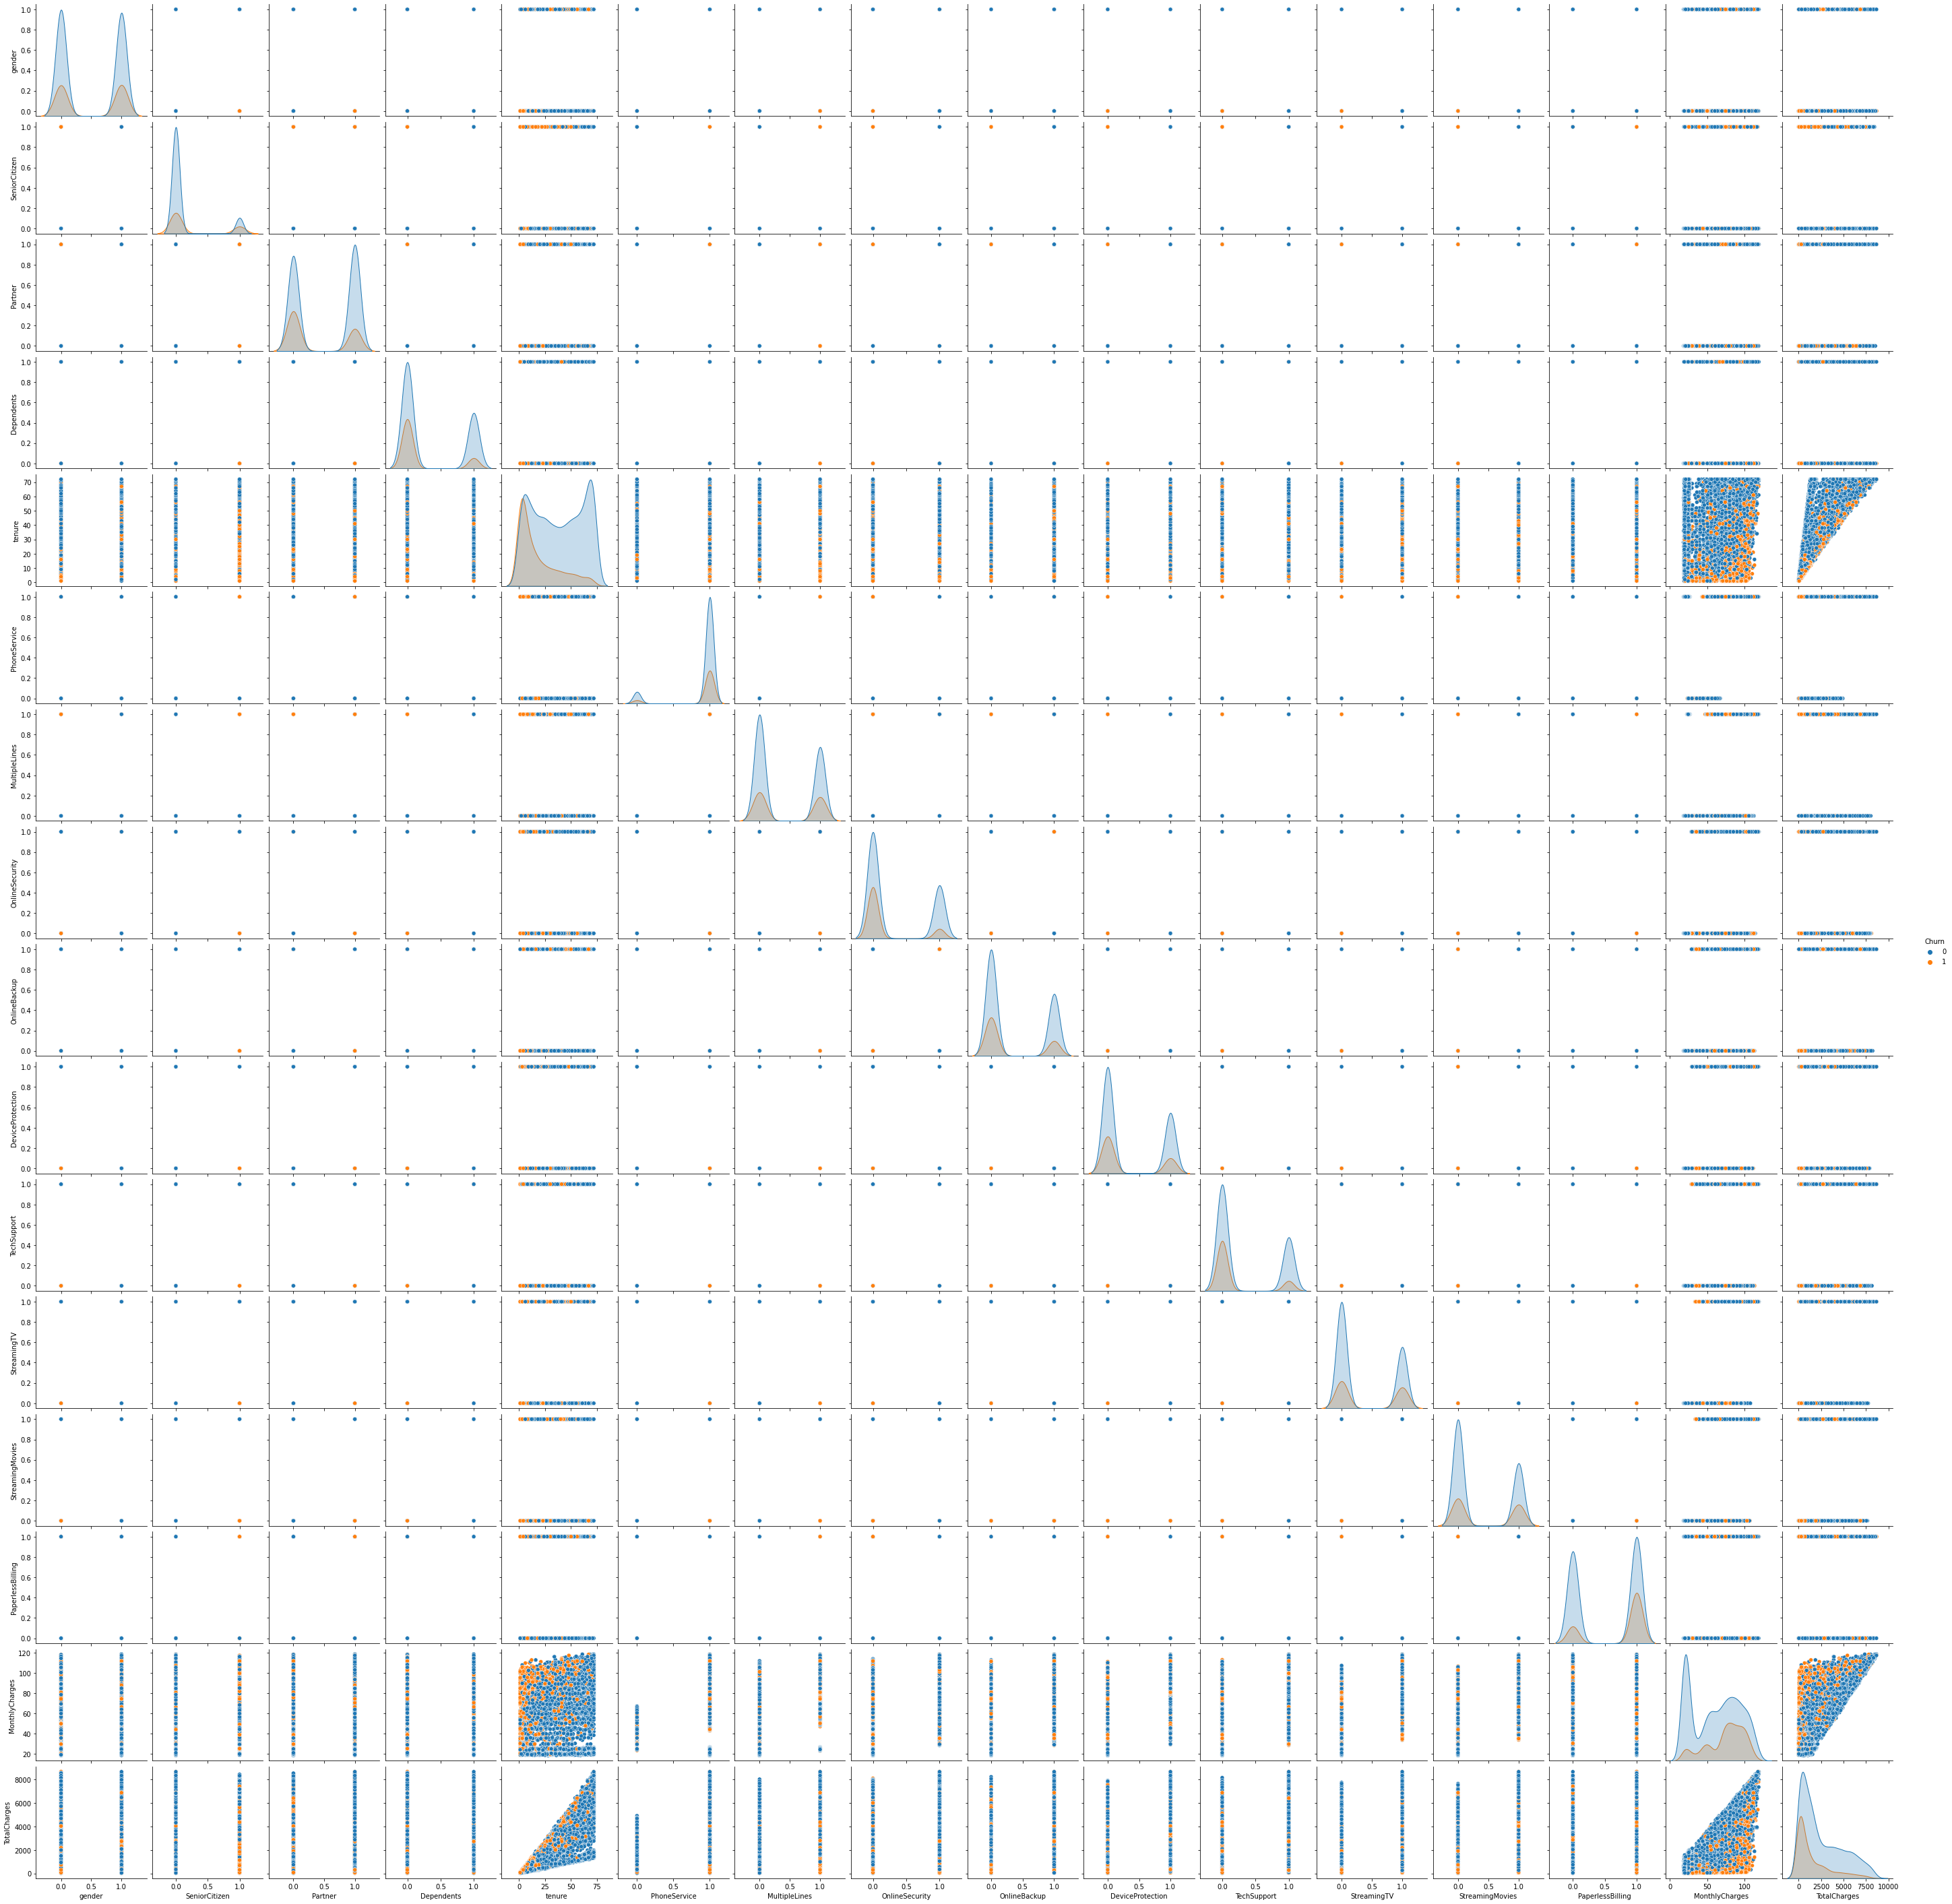

In [30]:
sns.pairplot(df2,hue='Churn')

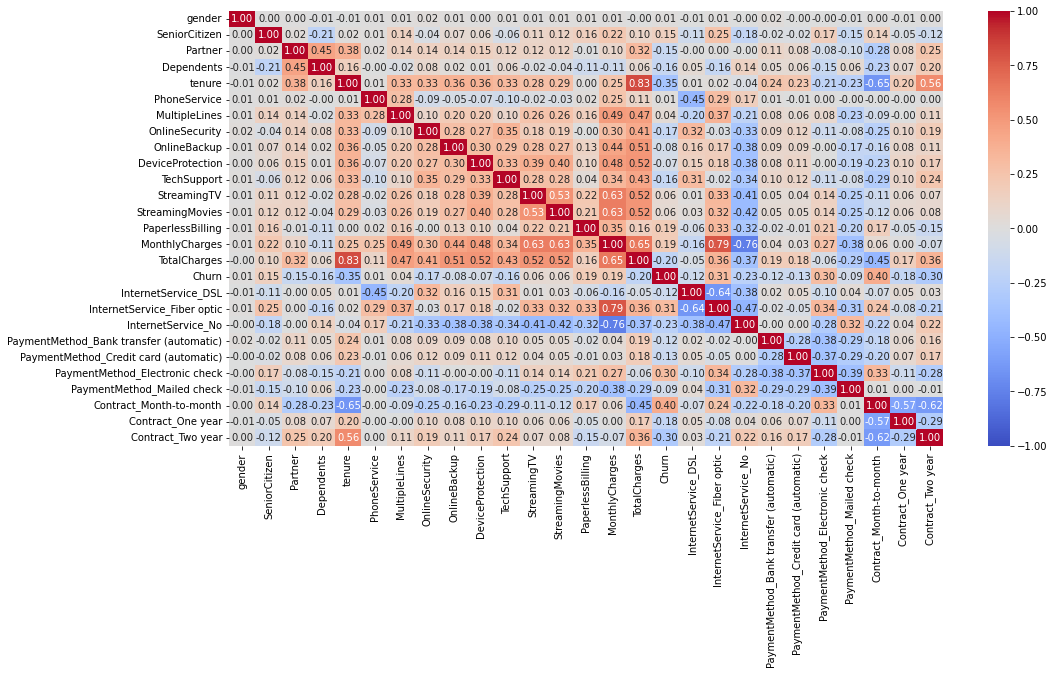

In [31]:
#Plottted heatmap on datset
plt.figure(figsize=(16, 8))
sns.heatmap (df.corr(), annot=True, fmt= '.2f', vmin=-1, vmax=1, center=0, cmap='coolwarm');

In [32]:
#removing columns with high collinearity
drop_col = ['tenure', 'StreamingTV', 'DeviceProtection',]
df = df.drop(drop_col, axis=1)
df.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,TechSupport,StreamingMovies,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Contract_Month-to-month,Contract_One year,Contract_Two year
0,1,0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,1,0,0
1,0,0,0,0,1,0,1,0,0,0,...,1,0,0,0,0,0,1,0,1,0
2,0,0,0,0,1,0,1,1,0,0,...,1,0,0,0,0,0,1,1,0,0
3,0,0,0,0,0,0,1,0,1,0,...,1,0,0,1,0,0,0,0,1,0
4,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0


In [33]:
df=df.astype(float)

In [34]:
df.dtypes

gender                                     float64
SeniorCitizen                              float64
Partner                                    float64
Dependents                                 float64
PhoneService                               float64
MultipleLines                              float64
OnlineSecurity                             float64
OnlineBackup                               float64
TechSupport                                float64
StreamingMovies                            float64
PaperlessBilling                           float64
MonthlyCharges                             float64
TotalCharges                               float64
Churn                                      float64
InternetService_DSL                        float64
InternetService_Fiber optic                float64
InternetService_No                         float64
PaymentMethod_Bank transfer (automatic)    float64
PaymentMethod_Credit card (automatic)      float64
PaymentMethod_Electronic check 

In [35]:
from statsmodels.stats.weightstats import ztest as ztest

#Using ztest for analysis of mean
#Checking mean value of the features is affected by Churn type or not
col_all=df.columns.values#['P_incidence','P_tilt','L_angle','S_slope','P_radius','S_Degree']
for i in col_all:
    print(' Ho:{} have same mean for both class type'.format(i))
    print('\n')
    print(' H1:{} does not have same mean for both class type  '.format(i))
    print('\n')
    
    
    df_normal=df[df.Churn==1][i]
    df_typeH=df[df.Churn==0][i]
    
    
    f_stats,p_value=ztest(df_normal,df_typeH)
    print(' F_stats: {}'.format(f_stats))
    print('p_value: {}'.format(p_value))
    
    if p_value < 0.05:  # Taking significance level as 5%
        print(' Rejecting Null Hypothesis.This means Churn type affects the value of {}'.format(i))
    else:
        print(' Fail to Reject Null Hypothesis.Churn types does not affect the value of {}'.format(i))
    print('\n')

 Ho:gender have same mean for both class type


 H1:gender does not have same mean for both class type  


 F_stats: 0.716452580112444
p_value: 0.4737119380344763
 Fail to Reject Null Hypothesis.Churn types does not affect the value of gender


 Ho:SeniorCitizen have same mean for both class type


 H1:SeniorCitizen does not have same mean for both class type  


 F_stats: 12.767631982935935
p_value: 2.486031080316528e-37
 Rejecting Null Hypothesis.This means Churn type affects the value of SeniorCitizen


 Ho:Partner have same mean for both class type


 H1:Partner does not have same mean for both class type  


 F_stats: -12.719118110385658
p_value: 4.630567614602974e-37
 Rejecting Null Hypothesis.This means Churn type affects the value of Partner


 Ho:Dependents have same mean for both class type


 H1:Dependents does not have same mean for both class type  


 F_stats: -13.86321957150497
p_value: 1.0581929993055425e-43
 Rejecting Null Hypothesis.This means Churn type affects the v

####Using ztest for analysis of mean when category are not greater 2
#### Null hypothesis Ho: have same mean for both class type. 
#### Alternative hypothesis H1: have does not have mean for both class type. 

In [36]:
drop_col = ['PhoneService', 'gender']
df = df.drop(drop_col, axis=1)
df.head()

,SeniorCitizen,Partner,Dependents,MultipleLines,OnlineSecurity,OnlineBackup,TechSupport,StreamingMovies,PaperlessBilling,MonthlyCharges,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Contract_Month-to-month,Contract_One year,Contract_Two year
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.115423,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.385075,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.354229,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.239303,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.521891,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [37]:
df.describe()

,SeniorCitizen,Partner,Dependents,MultipleLines,OnlineSecurity,OnlineBackup,TechSupport,StreamingMovies,PaperlessBilling,MonthlyCharges,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Contract_Month-to-month,Contract_One year,Contract_Two year
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,...,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,0.482509,0.298493,0.421928,0.286547,0.344852,0.290102,0.388367,0.592719,0.463166,...,0.343572,0.440273,0.216155,0.219283,0.216297,0.336320,0.228100,0.551052,0.209329,0.239619
std,0.368844,0.499729,0.457629,0.493902,0.452180,0.475354,0.453842,0.487414,0.491363,0.299363,...,0.474934,0.496455,0.411650,0.413790,0.411748,0.472483,0.419637,0.497422,0.406858,0.426881
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.172512,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.518408,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.712562,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [38]:
#Split churn vs remaining
x = df.drop('Churn',axis='columns')
y = df['Churn']

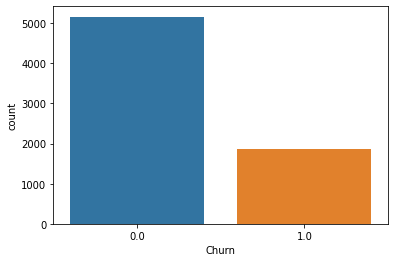

In [39]:
#Check balance of churn fields
import seaborn as sns
sns.countplot(y)

**Balance dataset by applying RandomOverSampler on x,y**

In [40]:
from imblearn.over_sampling import RandomOverSampler,SMOTE
over = RandomOverSampler()
x_s,y_s = over.fit_resample(x,y)
y_s.value_counts()

0.0    5163
1.0    5163
Name: Churn, dtype: int64

In [41]:
#split into test and train datset
X_train, X_test, y_train, y_test = train_test_split(x_s,y_s,test_size=0.2,random_state=5)

In [42]:
#Check train shape
X_train.shape

(8260, 21)

In [43]:
#Check tes shape
X_test.shape

(2066, 21)

In [44]:
#total number of columns
len(X_test.columns)

21

**Algorithm Comparison**

In [45]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC # "Support vector classifier" 
from sklearn.naive_bayes import GaussianNB  
from sklearn.ensemble import RandomForestClassifier  
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import AdaBoostClassifier
classifiers = [
    DecisionTreeClassifier(),
    KNeighborsClassifier(7), 
    SVC(kernel='linear', random_state=0),
    #LogisticRegression(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LogisticRegressionCV(solver='lbfgs', max_iter=5000, cv=5, multi_class='auto'),
    DecisionTreeClassifier(max_depth=5),
    AdaBoostClassifier()
]
names = []
scores = []

for clf in classifiers:
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    names.append(clf.__class__.__name__)
    scores.append(accuracy_score(y_pred, y_test))

score_df = pd.DataFrame({'Model': names, 'Score': scores}).set_index('Model')
score_df

,Score
Model,
DecisionTreeClassifier,0.864472
KNeighborsClassifier,0.761375
SVC,0.727493
RandomForestClassifier,0.875605
GradientBoostingClassifier,0.767667
GaussianNB,0.740561
LogisticRegressionCV,0.744918
DecisionTreeClassifier,0.742982
AdaBoostClassifier,0.752178


**Deep learning Algorithms**

In [46]:
#Apply basic ANN with Keras
ann_model = keras.Sequential([
    keras.layers.Dense(30, input_shape=(21,), activation='relu'),
    keras.layers.Dense(25, activation='relu'),
    keras.layers.Dense(10,activation = 'relu'),
    # we use sigmoid for binary output
    # output layer
    keras.layers.Dense(1, activation='sigmoid')
])

opt = keras.optimizers.Adam(learning_rate=0.01)
#opt = keras.optimizers.Adam(learning_rate=0.4)
ann_model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

ann_model.fit(X_train, y_train, epochs=1000)

Epoch 1/1000
259/259 [==============================] - 1s 2ms/step - loss: 0.5038 - accuracy: 0.7519
Epoch 2/1000
259/259 [==============================] - 1s 2ms/step - loss: 0.4868 - accuracy: 0.7613
Epoch 3/1000
259/259 [==============================] - 1s 2ms/step - loss: 0.4801 - accuracy: 0.7663
Epoch 4/1000
259/259 [==============================] - 1s 2ms/step - loss: 0.4731 - accuracy: 0.7680
Epoch 5/1000
259/259 [==============================] - 1s 2ms/step - loss: 0.4707 - accuracy: 0.7673
Epoch 6/1000
259/259 [==============================] - 1s 2ms/step - loss: 0.4688 - accuracy: 0.7729
Epoch 7/1000
259/259 [==============================] - 1s 2ms/step - loss: 0.4610 - accuracy: 0.7775
Epoch 8/1000
259/259 [==============================] - 1s 2ms/step - loss: 0.4590 - accuracy: 0.7787
Epoch 9/1000
259/259 [==============================] - 1s 2ms/step - loss: 0.4576 - accuracy: 0.7757
Epoch 10/1000
259/259 [==============================] - 1s 2ms/step - loss: 0.457

In [47]:
#evaluate model on test set
ann_model.evaluate(X_test, y_test)

65/65 [==============================] - 0s 2ms/step - loss: 0.8076 - accuracy: 0.8127


[0.8075702786445618, 0.8126814961433411]

In [48]:
#predict model on test set
y_pred = ann_model.predict(X_test)
y_pred[:5]

array([[8.9672887e-01],
       [1.0750880e-12],
       [7.6285315e-01],
       [7.1221340e-01],
       [0.0000000e+00]], dtype=float32)

In [49]:
# predict ANN model
yp = ann_model.predict(X_test)
y_pred = []
for element in yp:
    if element > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [50]:
y_pred[:10]

[1, 0, 1, 1, 0, 1, 0, 0, 0, 0]

In [51]:
#classification report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.70      0.79      1025
         1.0       0.76      0.93      0.83      1041

    accuracy                           0.81      2066
   macro avg       0.83      0.81      0.81      2066
weighted avg       0.83      0.81      0.81      2066



Text(69.0, 0.5, 'Truth')

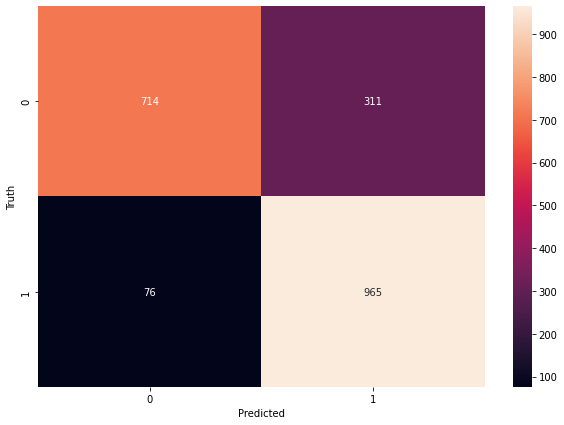

In [53]:
#confusion_matrix for ann model
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

**Hyper Parameter tuning - ANN**

In [54]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU,PReLU,ELU
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Flatten, LeakyReLU, BatchNormalization, Dropout
from keras.activations import relu, sigmoid

#create Hyper Parameter ANN model
def create_model(layers, activation):
    model = Sequential()
    for i, nodes in enumerate(layers):
        if i==0:
            model.add(Dense(nodes,input_dim=X_train.shape[1]))
            model.add(Activation(activation))
            model.add(Dropout(0.3))
        else:
            model.add(Dense(nodes))
            model.add(Activation(activation))
            model.add(Dropout(0.3))
            
    model.add(Dense(units =1 , activation = 'sigmoid')) # Note: no activation beyond this point
    
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
    return model
    
model = KerasClassifier(build_fn=create_model, verbose=0)


layers = [(26,), (20, 20), (15, 15)]
activations = ['sigmoid', 'relu']
param_grids = dict(layers=layers, activation=activations, batch_size = [128, 256], epochs=[30])
grid = GridSearchCV(estimator=model, param_grid=param_grids,cv=5)

In [55]:
grid_result=grid.fit(X_train, y_train)
[grid_result.best_score_,grid_result.best_params_]

[0.7646489024162293,
 {'activation': 'relu', 'batch_size': 128, 'epochs': 30, 'layers': (26,)}]

**FLASK API**

In [56]:
#Dump the ann model model in local

import joblib
#from sklearn.externals import joblib
import pickle

joblib.dump(ann_model, "ann_model.pkl")
# creating the app
import requests
from flask import Flask

from flask import request

app = Flask(__name__)

@app.route("/predict", methods=['POST'])
def predict():
            data = request.get_json()
            data1 = json_normalize(data)
            scaled_data=scaler.transform(data1)

            x_pca=p_c_a.transform(scaled_data)
             
            clf = joblib.load("./ann_model.pkl")

            return str(clf.predict(x_pca))
           
if __name__ == "__main__":
    #app.run(debug=False, host='0.0.0.0', port=5000)
    app.run(debug=False, host='127.0.0.1', port=5000)

INFO:tensorflow:Assets written to: ram://c82558c9-8a46-4b57-aa44-4cd149f202a1/assets
 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
